In [1]:
import os
import shutil
import random
from pathlib import Path

In [2]:
!wget "https://drive.usercontent.google.com/download?id=1bqNEIMWJO5FFBkH-Zk4WSO5174V8OGoa&export=download&authuser=0&confirm=t&uuid=fa54ab52-dab0-4be9-b9af-fd47647fbafe&at=AENtkXa3LwIk4Fz183O8_3Apgf6i:1732844546889" -O trash_data.zip


--2024-11-29 01:44:41--  https://drive.usercontent.google.com/download?id=1bqNEIMWJO5FFBkH-Zk4WSO5174V8OGoa&export=download&authuser=0&confirm=t&uuid=fa54ab52-dab0-4be9-b9af-fd47647fbafe&at=AENtkXa3LwIk4Fz183O8_3Apgf6i:1732844546889
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.200.132, 2404:6800:4003:c00::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.200.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 205871950 (196M) [application/octet-stream]
Saving to: ‘trash_data.zip’

trash_data.zip      100%[===================>] 196.33M   181MB/s    in 1.1s    

2024-11-29 01:44:44 (181 MB/s) - ‘trash_data.zip’ saved [205871950/205871950]



In [3]:
!unzip -o -q trash_data.zip -d data

In [6]:
data_dir = './data/data3'
output_dir = './split_data'

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

label = os.listdir(data_dir)
print(label)

['disc', 'paper', 'ceramicsbowl', 'plasticbag', 'pen', 'glassbottle', 'bottlecap', 'newspaper', 'cans', 'galvanizedsteel', 'cardboard']


In [7]:
# Buat folder untuk split dataset
Path(output_dir).mkdir(parents=True, exist_ok=True)
for split in ['train', 'val', 'test']:
    (Path(output_dir) / split).mkdir(parents=True, exist_ok=True)

In [8]:
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)  # misal ./data/ada_class
    if not os.path.isdir(class_dir):
        continue

    # Buat folder untuk masing-masing class di train, val, dan test
    for split in ['train', 'val', 'test']:
        split_class_dir = os.path.join(output_dir, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

    # Dapatkan semua file gambar dalam folder class
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
    random.shuffle(images)

    # Tentukan jumlah data untuk setiap split
    train_count = int(len(images) * train_ratio)
    val_count = int(len(images) * val_ratio)
    test_count = len(images) - train_count - val_count

    # Bagi dataset
    train_images = images[:train_count]
    val_images = images[train_count:train_count + val_count]
    test_images = images[train_count + val_count:]

    # Salin gambar ke folder split masing-masing
    for img in train_images:
        shutil.copy(img, os.path.join(output_dir, 'train', class_name))
    for img in val_images:
        shutil.copy(img, os.path.join(output_dir, 'val', class_name))
    for img in test_images:
        shutil.copy(img, os.path.join(output_dir, 'test', class_name))

print("Dataset berhasil dibagi!")

Dataset berhasil dibagi!


In [9]:
import tensorflow as tf

In [20]:
data_dir = './split_data'

# Parameter dataset
image_size = (224, 224)
batch_size = 32

In [21]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=f'{data_dir}/train',
    labels='inferred',
    label_mode='categorical',  # Menggunakan one-hot encoding
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=f'{data_dir}/val',
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False  # Tidak perlu diacak
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=f'{data_dir}/test',
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False  # Tidak perlu diacak
)

# Periksa struktur dataset
print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)
print("Test Dataset:", test_dataset)

Found 7782 files belonging to 11 classes.
Found 968 files belonging to 11 classes.
Found 983 files belonging to 11 classes.
Train Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 11), dtype=tf.float32, name=None))>
Validation Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 11), dtype=tf.float32, name=None))>
Test Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 11), dtype=tf.float32, name=None))>


In [22]:
train_dataset_final = train_dataset.cache().shuffle(
    1000,
    reshuffle_each_iteration=True
).prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset_final = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset_final = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


In [32]:
models = tf.keras.models
layers = tf.keras.layers

model = tf.keras.models.Sequential([

    # Augmentasi yang lebih agresif
    # tf.keras.layers.RandomRotation(0.2, fill_mode="nearest"),
    # tf.keras.layers.RandomContrast(0.2),
    # tf.keras.Input(shape=),
    tf.keras.layers.RandomFlip("horizontal_and_vertical", input_shape=(224, 224, 3)),
    tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode="nearest"),
    tf.keras.layers.RandomZoom(0.2, fill_mode="nearest"),
    tf.keras.layers.RandomBrightness(0.2),

    tf.keras.layers.Rescaling(1./255),

    tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(len(label), activation='softmax')

    # # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.Conv2D(64, (3, 3), activation="relu", kernel_regularizer=l2(0.001)),
    # tf.keras.layers.BatchNormalization()
    # tf.keras.layers.Dropout(0.3),
    # tf.keras.layers.Conv2D(512, (3, 3), activation="relu", kernel_regularizer=l2(0.001)),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dropout(0.3),

    # Dense layers dengan regularisasi yang lebih kuat
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Activation('relu'),
    # tf.keras.layers.Dropout(0.5),

])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_4 (RandomFlip)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation                   │ (None, 224, 224, 3)         │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_4 (RandomZoom)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_brightness (RandomBrightness) │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_4 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │      44,302,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 11)                  │           5,643 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,401,739 (169.38 MB)

 Trainable params: 44,401,739 (169.38 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.000085, rho=0.8),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 6e-4 * 10**(epoch / 20))

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001
)

class PrintLearningRate(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        print(f"Learning rate at epoch {epoch + 1}: {lr}")

In [43]:
history = model.fit(
    train_dataset_final,
    validation_data=val_dataset_final,
    epochs=30,
    verbose=2,
    callbacks=[early_stopping,]
)

Epoch 1/30
244/244 - 17s - 69ms/step - accuracy: 0.6480 - loss: 1.0594 - val_accuracy: 0.6364 - val_loss: 1.1401
Epoch 2/30
244/244 - 20s - 83ms/step - accuracy: 0.6497 - loss: 1.0570 - val_accuracy: 0.6415 - val_loss: 1.1342
Epoch 3/30
244/244 - 17s - 68ms/step - accuracy: 0.6483 - loss: 1.0537 - val_accuracy: 0.6343 - val_loss: 1.1297
Epoch 4/30
244/244 - 17s - 69ms/step - accuracy: 0.6506 - loss: 1.0529 - val_accuracy: 0.6333 - val_loss: 1.1393
Epoch 5/30
244/244 - 18s - 73ms/step - accuracy: 0.6584 - loss: 1.0316 - val_accuracy: 0.6519 - val_loss: 1.1087
Epoch 6/30
244/244 - 17s - 70ms/step - accuracy: 0.6605 - loss: 1.0317 - val_accuracy: 0.6384 - val_loss: 1.1048
Epoch 7/30
244/244 - 18s - 73ms/step - accuracy: 0.6650 - loss: 1.0249 - val_accuracy: 0.6653 - val_loss: 1.0648
Epoch 8/30
244/244 - 20s - 80ms/step - accuracy: 0.6682 - loss: 1.0015 - val_accuracy: 0.6550 - val_loss: 1.0697
Epoch 9/30
244/244 - 17s - 70ms/step - accuracy: 0.6708 - loss: 0.9956 - val_accuracy: 0.6622 - 

In [ ]:
 loss, accuracy = model.evaluate(test_dataset)
print("Accuracy", accuracy)

75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5099 - loss: 1.7226
Accuracy 0.5169811248779297


In [26]:
import matplotlib.pyplot as plt

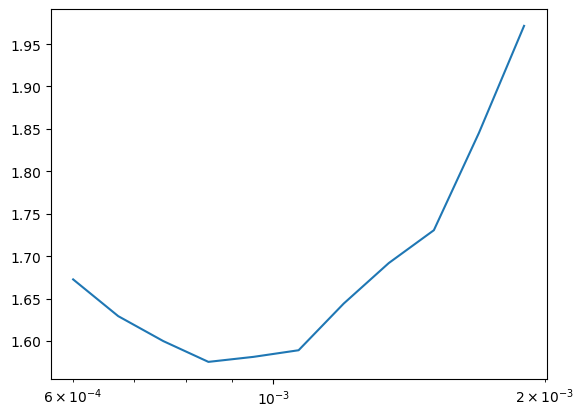

In [39]:
plt.semilogx(history.history['learning_rate'], history.history['loss'])

In [27]:
def plot_loss_acc(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(len(acc))

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
  ax1.plot(epochs_range, acc, label='Training Accuracy')
  ax1.plot(epochs_range, val_acc, label='Validation Accuracy')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Accuracy')
  ax1.set_title('Training and Validation Accuracy')
  ax1.legend()

  ax2.plot(epochs_range, loss, label='Training Loss')
  ax2.plot(epochs_range, val_loss, label='Validation Loss')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss')
  ax2.set_title('Training and Validation Loss')
  ax2.legend()

  plt.tight_layout()
  plt.show()

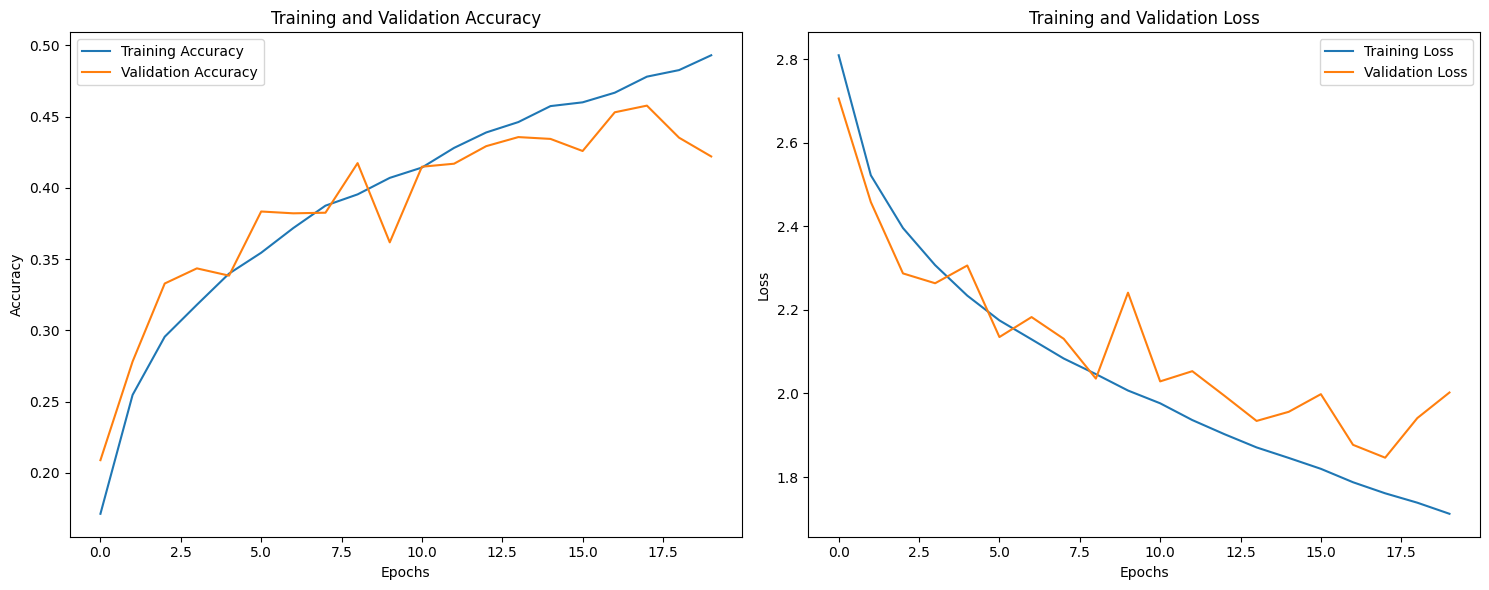

In [ ]:
plot_loss_acc(history)


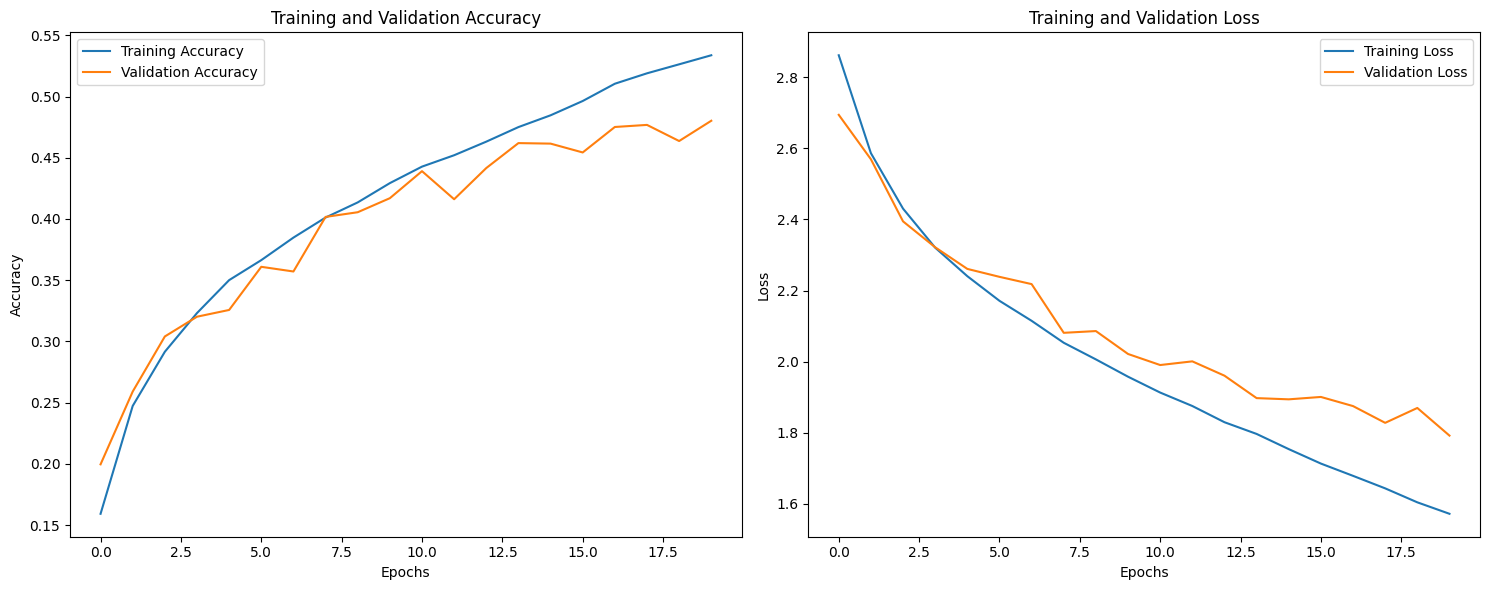

In [ ]:
plot_loss_acc(history)

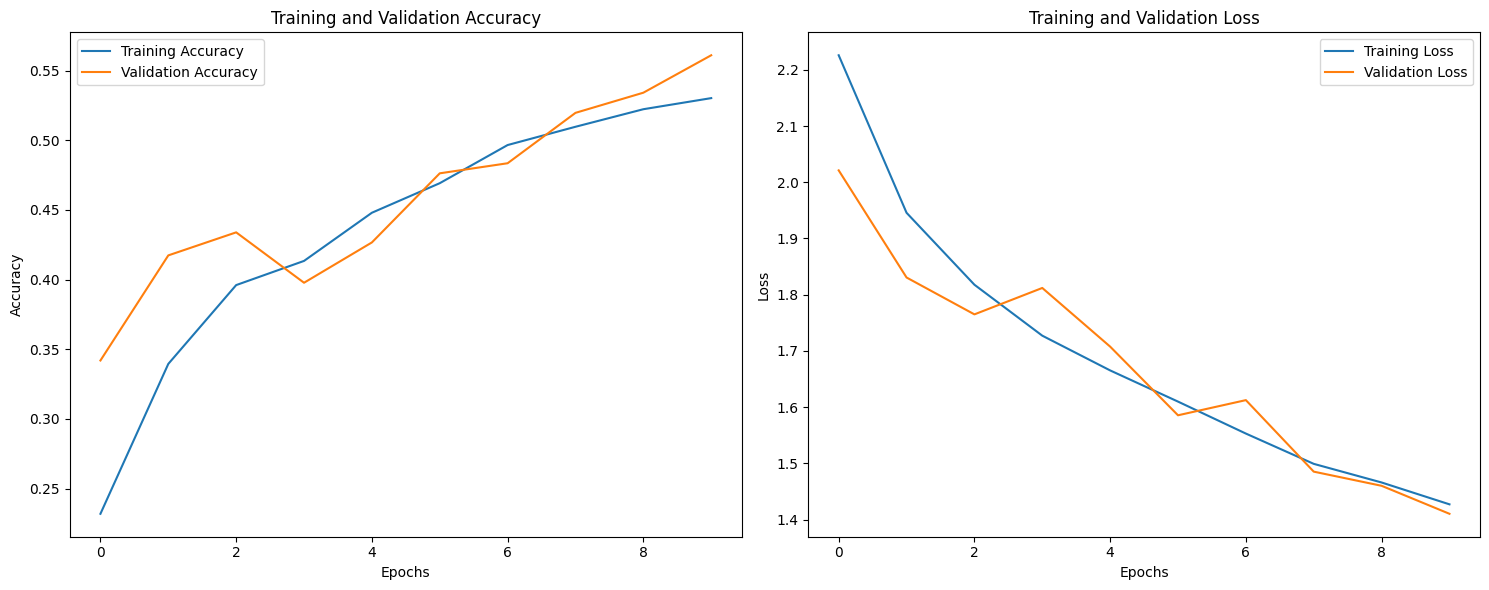

In [28]:
# rmsProp 5 10-4 . 32 64 128 | 512
plot_loss_acc(history)

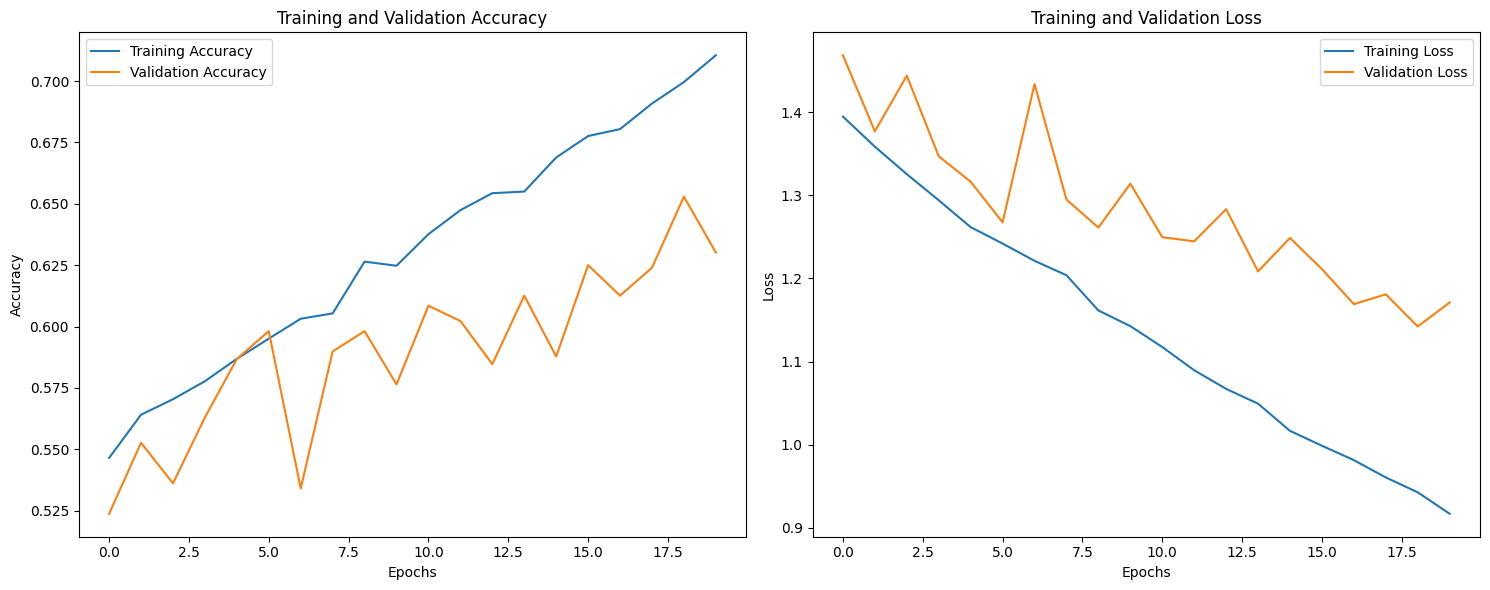

In [30]:
# rmsProp 5 10-4 . 32 64 128 | 512 | epoch 20
plot_loss_acc(history)

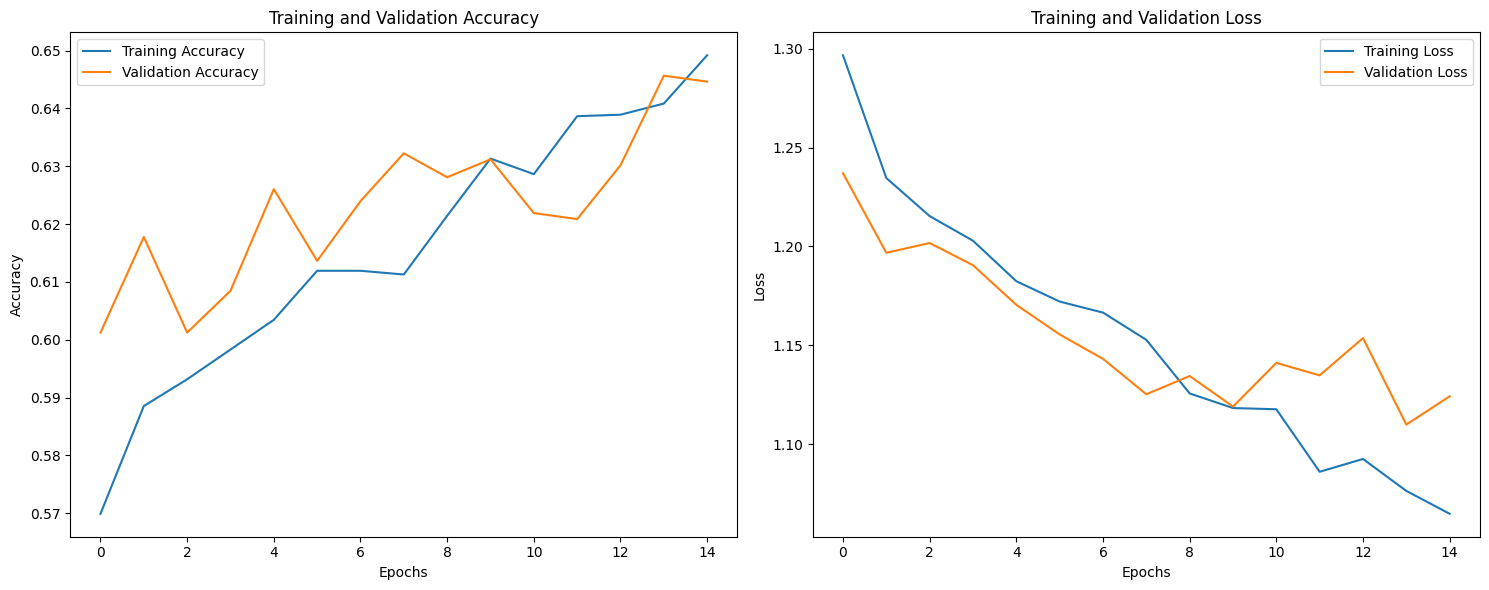

In [42]:
# tambah augmentasi 3 | rmsProp rho=0.8 lr=85-10-4 | 32 64 128 | 512 | epoch 15
plot_loss_acc(history)

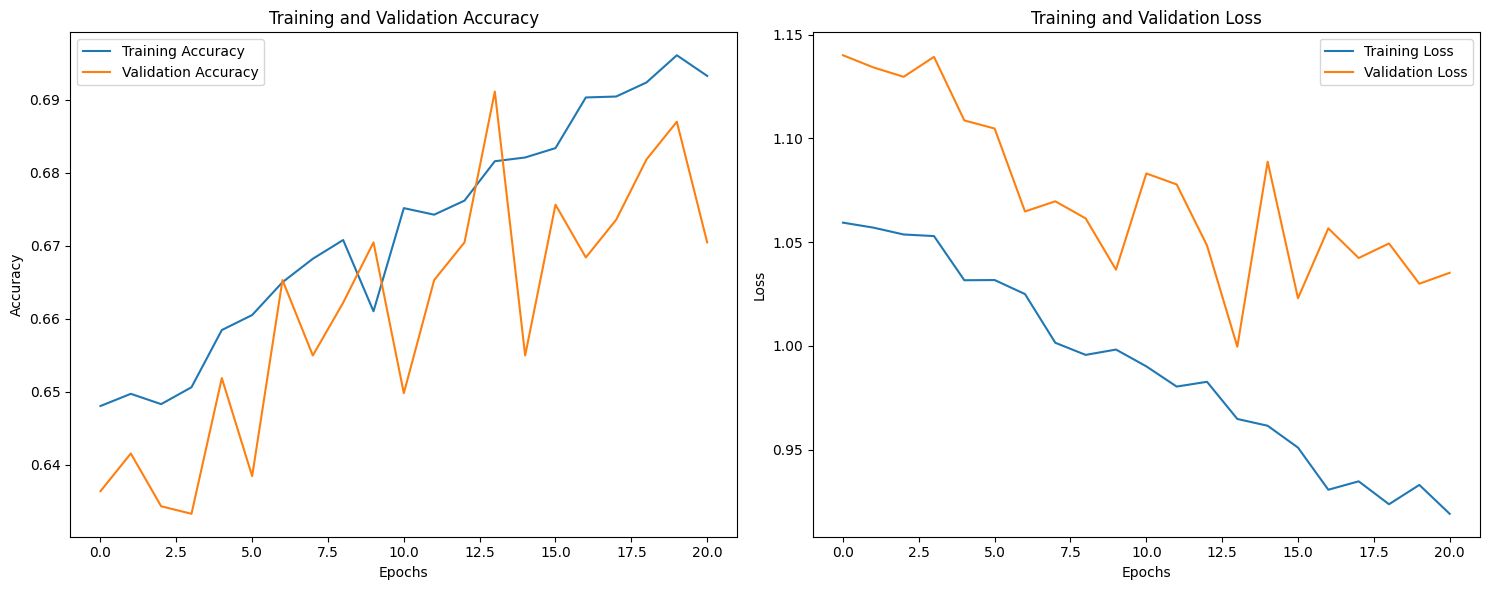

In [44]:
# tambah augmentasi 3 | rmsProp rho=0.8 lr=85-10-4 | 32 64 128 | 512 | epoch 21
plot_loss_acc(history)